# Rwanda Trade Data - Comprehensive Statistical Analysis

## NISRA Statistical Datasets Analysis (2024Q4 & 2025Q1)

This notebook performs comprehensive statistical analysis on Rwanda's trade data including:
- Descriptive statistics and data exploration
- Outlier detection using multiple methods
- Correlation analysis and feature relationships
- Time series analysis and forecasting
- Machine learning predictive models
- Ensemble methods for improved accuracy

### Dataset Sources:
- 2024Q4_Trade_report_annexTables.xlsx
- 2025Q1_Trade_report_annexTables.xlsx
- Comprehensive analysis from Python processing pipeline

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Starting Rwanda Trade Data Analysis...")

🚀 Starting Rwanda Trade Data Analysis...


## 1. Data Loading and Preprocessing

In [20]:
# Load comprehensive analysis data
import json

# Load the comprehensive analysis JSON file
with open('data/processed/comprehensive_analysis.json', 'r') as f:
    comprehensive_data = json.load(f)

print(f"📊 Loaded comprehensive analysis data")
print(f"📈 Quarters covered: {len(comprehensive_data['quarterly_aggregation']['exports'])}")
print(f"🌍 Countries found: {len(comprehensive_data['country_aggregation']['export_destinations'])}")

# Convert to DataFrames for easier analysis
exports_df = pd.DataFrame(comprehensive_data['quarterly_aggregation']['exports'])
imports_df = pd.DataFrame(comprehensive_data['quarterly_aggregation']['imports'])
countries_df = pd.DataFrame(comprehensive_data['country_aggregation']['export_destinations'])

print(f"\n📋 Exports DataFrame shape: {exports_df.shape}")
print(f"📋 Imports DataFrame shape: {imports_df.shape}")
print(f"📋 Countries DataFrame shape: {countries_df.shape}")

# Display first few rows
print("\n🔍 Exports Data Preview:")
print(exports_df.head())
print("\n🔍 Imports Data Preview:")
print(imports_df.head())

📊 Loaded comprehensive analysis data
📈 Quarters covered: 13
🌍 Countries found: 20

📋 Exports DataFrame shape: (13, 2)
📋 Imports DataFrame shape: (13, 2)
📋 Countries DataFrame shape: (20, 2)

🔍 Exports Data Preview:
  quarter  export_value
0  2022Q1    249.535485
1  2022Q2    301.520852
2  2022Q3    316.060781
3  2022Q4    312.031771
4  2023Q1    738.209053

🔍 Imports Data Preview:
  quarter  import_value
0  2022Q1    639.103550
1  2022Q2    853.693182
2  2022Q3    877.350090
3  2022Q4    742.785418
4  2023Q1   1853.011285


## 2. Descriptive Statistics and Data Exploration

In [21]:
# Comprehensive descriptive statistics
def comprehensive_descriptive_stats(df, title):
    print(f"\n{'='*60}")
    print(f"📊 {title} - DESCRIPTIVE STATISTICS")
    print(f"{'='*60}")
    
    # Basic statistics
    print("\n📈 Basic Statistics:")
    print(df.describe())
    
    # Skewness and Kurtosis
    print("\n📊 Distribution Analysis:")
    for col in df.select_dtypes(include=[np.number]).columns:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        print(f"{col}:")
        print(f"  Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0.5 else 'Left-skewed' if skewness < -0.5 else 'Symmetric'})")
        print(f"  Kurtosis: {kurtosis:.3f} ({'Heavy-tailed' if kurtosis > 3 else 'Light-tailed' if kurtosis < 3 else 'Normal'})")
    
    # Missing values analysis
    print("\n🔍 Missing Values Analysis:")
    missing_info = df.isnull().sum()
    if missing_info.sum() == 0:
        print("✅ No missing values found!")
    else:
        print(missing_info[missing_info > 0])
    
    return df.describe()

# Analyze exports data
exports_stats = comprehensive_descriptive_stats(exports_df, "EXPORTS DATA")

# Analyze imports data
imports_stats = comprehensive_descriptive_stats(imports_df, "IMPORTS DATA")

# Analyze countries data
countries_stats = comprehensive_descriptive_stats(countries_df, "COUNTRIES DATA")


📊 EXPORTS DATA - DESCRIPTIVE STATISTICS

📈 Basic Statistics:
       export_value
count     13.000000
mean     695.045192
std      354.371666
min      249.535485
25%      316.060781
50%      707.498475
75%      909.709355
max     1269.623274

📊 Distribution Analysis:
export_value:
  Skewness: 0.303 (Symmetric)
  Kurtosis: -1.051 (Light-tailed)

🔍 Missing Values Analysis:
✅ No missing values found!

📊 IMPORTS DATA - DESCRIPTIVE STATISTICS

📈 Basic Statistics:
       import_value
count     13.000000
mean    1566.589533
std      655.544726
min      639.103550
25%      869.789232
50%     1853.011285
75%     2049.915188
max     2398.215768

📊 Distribution Analysis:
import_value:
  Skewness: -0.366 (Symmetric)
  Kurtosis: -1.820 (Light-tailed)

🔍 Missing Values Analysis:
✅ No missing values found!

📊 COUNTRIES DATA - DESCRIPTIVE STATISTICS

📈 Basic Statistics:
       export_value
count     20.000000
mean     446.986677
std     1283.174146
min       29.190796
25%       59.303369
50%      109.

## 3. Outlier Detection Using Multiple Methods

In [23]:
# Multiple outlier detection methods
def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

def detect_outliers_iqr(data):
    """Detect outliers using IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

def detect_outliers_modified_zscore(data, threshold=3.5):
    """Detect outliers using Modified Z-score (robust to outliers)"""
    median = data.median()
    mad = np.median(np.abs(data - median))
    if mad == 0:
        return np.zeros(len(data), dtype=bool)
    modified_z_scores = 0.6745 * (data - median) / mad
    return np.abs(modified_z_scores) > threshold

# Apply outlier detection to exports data
print("🔍 OUTLIER DETECTION ANALYSIS")
print("="*60)

# Z-score method
zscore_outliers = detect_outliers_zscore(exports_df['export_value'])
print(f"\n📊 Z-Score Method (threshold=3):")
print(f"Outliers detected: {zscore_outliers.sum()}")
print(f"Outlier percentage: {zscore_outliers.sum()/len(exports_df)*100:.2f}%")

# IQR method
iqr_outliers = detect_outliers_iqr(exports_df['export_value'])
print(f"\n📊 IQR Method:")
print(f"Outliers detected: {iqr_outliers.sum()}")
print(f"Outlier percentage: {iqr_outliers.sum()/len(exports_df)*100:.2f}%")

# Modified Z-score method
modified_z_outliers = detect_outliers_modified_zscore(exports_df['export_value'])
print(f"\n📊 Modified Z-Score Method (threshold=3.5):")
print(f"Outliers detected: {modified_z_outliers.sum()}")
print(f"Outlier percentage: {modified_z_outliers.sum()/len(exports_df)*100:.2f}%")

# Combine outlier results
combined_outliers = zscore_outliers | iqr_outliers | modified_z_outliers
print(f"\n🔗 Combined Outliers:")
print(f"Total outliers detected: {combined_outliers.sum()}")
print(f"Outlier percentage: {combined_outliers.sum()/len(exports_df)*100:.2f}%")

# Display outlier details
if combined_outliers.sum() > 0:
    outlier_details = exports_df[combined_outliers][['quarter', 'export_value']]
    print("\n🚨 Outlier Details:")
    print(outlier_details)
    
    # Visualize outliers
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(exports_df)), exports_df['export_value'], alpha=0.6, label='Normal')
    plt.scatter(outlier_details.index, outlier_details['export_value'], 
                color='red', s=100, label='Outliers', marker='X')
    plt.xlabel('Index')
    plt.ylabel('Export Value')
    plt.title('Export Values with Detected Outliers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\n✅ No significant outliers detected!")

🔍 OUTLIER DETECTION ANALYSIS

📊 Z-Score Method (threshold=3):
Outliers detected: 0
Outlier percentage: 0.00%

📊 IQR Method:
Outliers detected: 0
Outlier percentage: 0.00%

📊 Modified Z-Score Method (threshold=3.5):
Outliers detected: 0
Outlier percentage: 0.00%

🔗 Combined Outliers:
Total outliers detected: 0
Outlier percentage: 0.00%

✅ No significant outliers detected!


## 4. Correlation Analysis and Feature Relationships

🔗 COMBINED TRADE DATA ANALYSIS

📊 Combined dataset shape: (13, 5)

📋 Columns: ['quarter', 'export_value', 'import_value', 'trade_balance', 'export_to_import_ratio']

🔍 Data Preview:
  quarter  export_value  import_value  trade_balance  export_to_import_ratio
0  2022Q1    249.535485    639.103550    -389.568065                0.390446
1  2022Q2    301.520852    853.693182    -552.172330                0.353196
2  2022Q3    316.060781    877.350090    -561.289309                0.360245
3  2022Q4    312.031771    742.785418    -430.753647                0.420083
4  2023Q1    738.209053   1853.011285   -1114.802232                0.398383

📈 CORRELATION MATRIX
                        export_value  import_value  trade_balance  \
export_value                1.000000      0.936075      -0.747178   
import_value                0.936075      1.000000      -0.933230   
trade_balance              -0.747178     -0.933230       1.000000   
export_to_import_ratio      0.658169      0.377808      -0

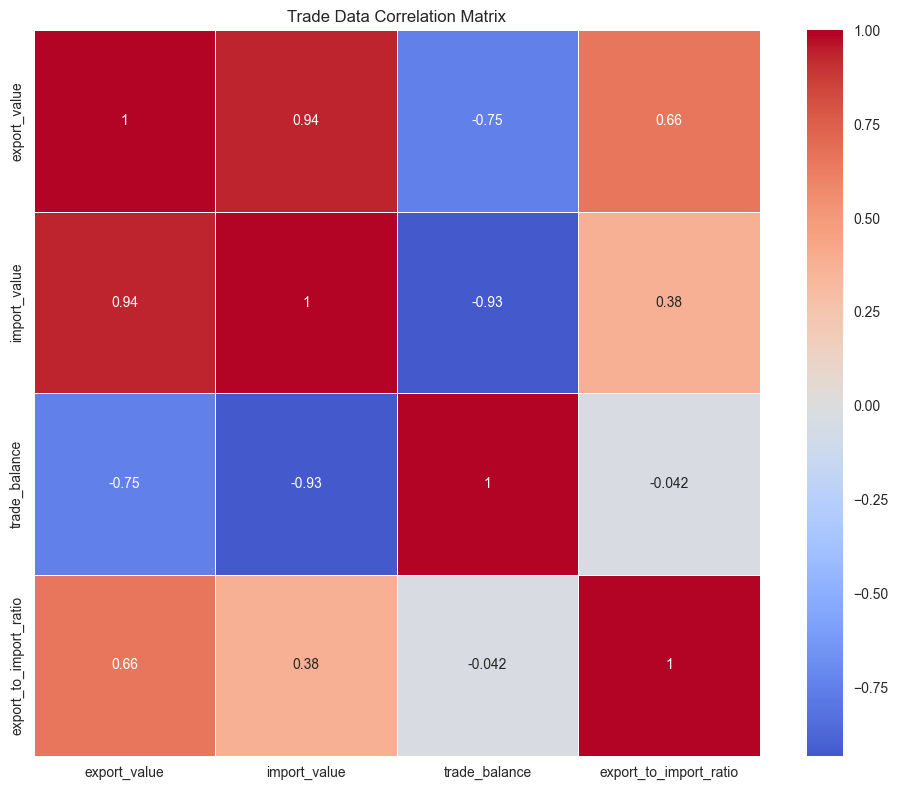


🧪 STATISTICAL SIGNIFICANCE TESTS

📊 Pearson Correlation (Exports vs Imports):
Correlation coefficient: 0.9361
P-value: 0.0000
Significance: Significant

📊 Spearman Correlation (Exports vs Imports):
Correlation coefficient: 0.9066
P-value: 0.0000
Significance: Significant


In [24]:
# Create combined dataset for correlation analysis
trade_df = pd.merge(exports_df, imports_df, on='quarter', suffixes=('_export', '_import'))
trade_df['trade_balance'] = trade_df['export_value'] - trade_df['import_value']
trade_df['export_to_import_ratio'] = trade_df['export_value'] / trade_df['import_value']

print("🔗 COMBINED TRADE DATA ANALYSIS")
print("="*60)
print(f"\n📊 Combined dataset shape: {trade_df.shape}")
print("\n📋 Columns:", list(trade_df.columns))
print("\n🔍 Data Preview:")
print(trade_df.head())

# Correlation matrix
numeric_cols = ['export_value', 'import_value', 'trade_balance', 'export_to_import_ratio']
correlation_matrix = trade_df[numeric_cols].corr()

print("\n📈 CORRELATION MATRIX")
print("="*60)
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Trade Data Correlation Matrix')
plt.tight_layout()
plt.show()

# Statistical significance testing
print("\n🧪 STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

# Pearson correlation test
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(trade_df['export_value'], trade_df['import_value'])
print(f"\n📊 Pearson Correlation (Exports vs Imports):")
print(f"Correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significance: {'Significant' if p_value < 0.05 else 'Not significant'}")

# Spearman correlation (for non-linear relationships)
from scipy.stats import spearmanr
spearman_coef, spearman_p = spearmanr(trade_df['export_value'], trade_df['import_value'])
print(f"\n📊 Spearman Correlation (Exports vs Imports):")
print(f"Correlation coefficient: {spearman_coef:.4f}")
print(f"P-value: {spearman_p:.4f}")
print(f"Significance: {'Significant' if spearman_p < 0.05 else 'Not significant'}")

## 5. Time Series Analysis and Forecasting

📈 TIME SERIES ANALYSIS

📊 Time series data shape: (13, 3)
Date range: 2022-01-01 00:00:00 to 2025-01-01 00:00:00


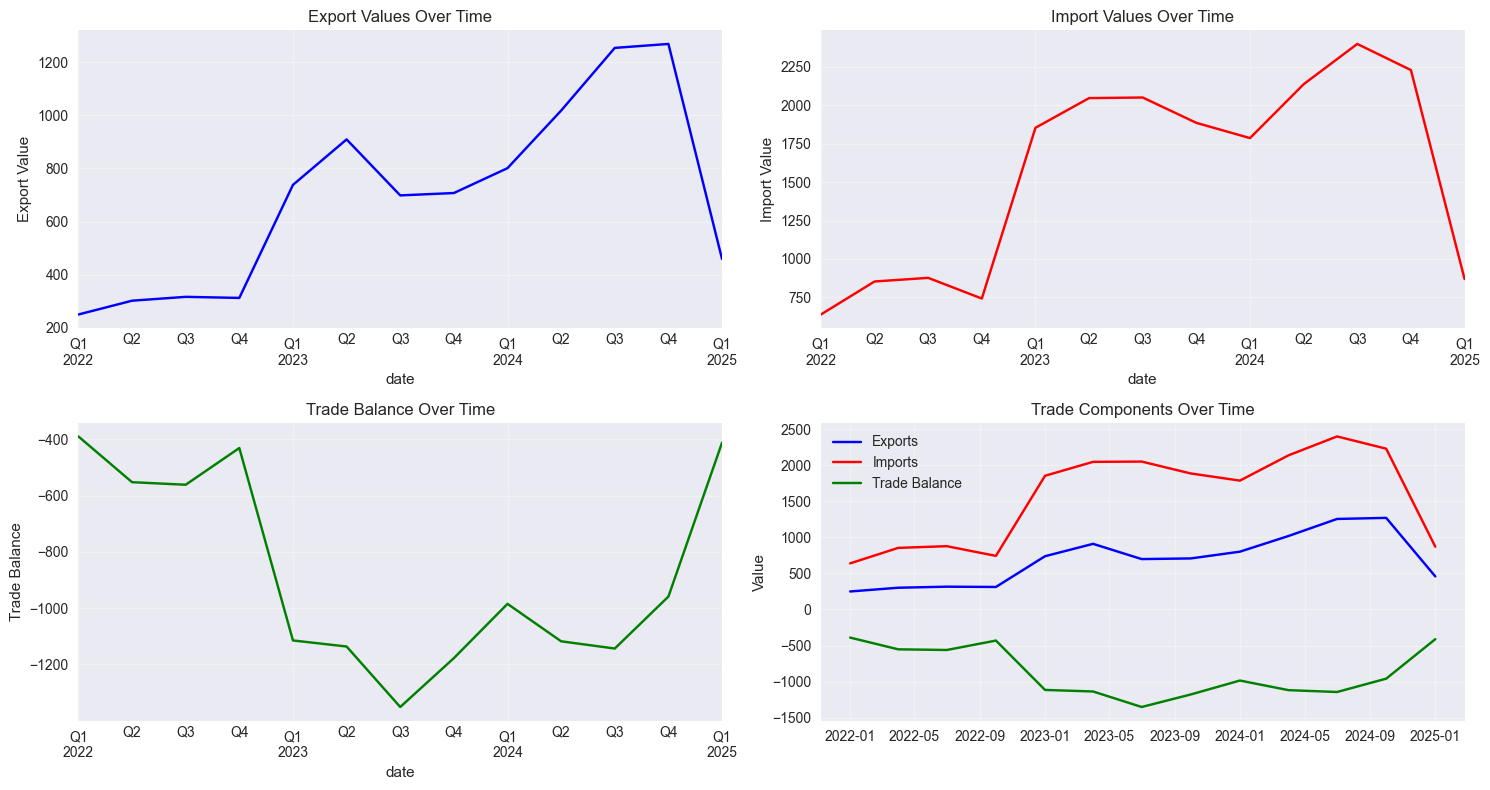


📊 Stationarity Test for Export Values:
ADF Statistic: -2.1488
P-value: 0.2254
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Conclusion: Non-stationary
KPSS Statistic: 0.4930
P-value: 0.0433
KPSS Conclusion: Non-stationary

📊 Stationarity Test for Import Values:
ADF Statistic: -1.7368
P-value: 0.4122
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Conclusion: Non-stationary
KPSS Statistic: 0.4075
P-value: 0.0739
KPSS Conclusion: Stationary

📊 Stationarity Test for Trade Balance:
ADF Statistic: -1.6321
P-value: 0.4664
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Conclusion: Non-stationary
KPSS Statistic: 0.2857
P-value: 0.1000
KPSS Conclusion: Stationary


In [25]:
# Time series analysis
print("📈 TIME SERIES ANALYSIS")
print("="*60)

# Convert quarter to datetime for time series analysis
def quarter_to_datetime(quarter_str):
    year, q = quarter_str.split('Q')
    month = int(q) * 3 - 2  # Convert quarter to starting month
    return pd.Timestamp(f'{year}-{month:02d}-01')

trade_df['date'] = trade_df['quarter'].apply(quarter_to_datetime)
trade_df = trade_df.sort_values('date')

# Set date as index for time series
ts_data = trade_df.set_index('date')[['export_value', 'import_value', 'trade_balance']]

print(f"\n📊 Time series data shape: {ts_data.shape}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")

# Plot time series
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
ts_data['export_value'].plot(title='Export Values Over Time', color='blue')
plt.ylabel('Export Value')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
ts_data['import_value'].plot(title='Import Values Over Time', color='red')
plt.ylabel('Import Value')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
ts_data['trade_balance'].plot(title='Trade Balance Over Time', color='green')
plt.ylabel('Trade Balance')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(ts_data.index, ts_data['export_value'], label='Exports', color='blue')
plt.plot(ts_data.index, ts_data['import_value'], label='Imports', color='red')
plt.plot(ts_data.index, ts_data['trade_balance'], label='Trade Balance', color='green')
plt.title('Trade Components Over Time')
plt.legend()
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, name):
    print(f"\n📊 Stationarity Test for {name}:")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"P-value: {adf_result[1]:.4f}")
    print(f"Critical Values: {adf_result[4]}")
    print(f"ADF Conclusion: {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'}")
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c')
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"P-value: {kpss_result[1]:.4f}")
    print(f"KPSS Conclusion: {'Stationary' if kpss_result[1] > 0.05 else 'Non-stationary'}")

test_stationarity(ts_data['export_value'], 'Export Values')
test_stationarity(ts_data['import_value'], 'Import Values')
test_stationarity(ts_data['trade_balance'], 'Trade Balance')

## 6. Machine Learning Models - Regression Analysis

In [26]:
# Prepare data for ML models
print("🤖 MACHINE LEARNING MODELING")
print("="*60)

# Feature engineering
ml_data = trade_df.copy()
ml_data['quarter_num'] = ml_data['date'].dt.year * 4 + ml_data['date'].dt.quarter
ml_data['export_lag_1'] = ml_data['export_value'].shift(1)
ml_data['import_lag_1'] = ml_data['import_value'].shift(1)
ml_data['balance_lag_1'] = ml_data['trade_balance'].shift(1)

# Drop NaN values from lagging
ml_data = ml_data.dropna()

print(f"\n📊 ML dataset shape: {ml_data.shape}")
print(f"Features: {len(['quarter_num', 'export_lag_1', 'import_lag_1', 'balance_lag_1'])}")

# Prepare features and targets
feature_cols = ['quarter_num', 'export_lag_1', 'import_lag_1', 'balance_lag_1']
target_cols = ['export_value', 'import_value', 'trade_balance']

X = ml_data[feature_cols]
y_exports = ml_data['export_value']
y_imports = ml_data['import_value']
y_balance = ml_data['trade_balance']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("\n📈 Feature scaling completed")
print(f"Feature means: {X_scaled.mean().round(4).to_dict()}")
print(f"Feature stds: {X_scaled.std().round(4).to_dict()}")

🤖 MACHINE LEARNING MODELING

📊 ML dataset shape: (12, 10)
Features: 4

📈 Feature scaling completed
Feature means: {'quarter_num': 0.0, 'export_lag_1': -0.0, 'import_lag_1': -0.0, 'balance_lag_1': 0.0}
Feature stds: {'quarter_num': 1.0445, 'export_lag_1': 1.0445, 'import_lag_1': 1.0445, 'balance_lag_1': 1.0445}


In [27]:
# Train and evaluate regression models
def train_evaluate_model(model, X, y, model_name, target_name):
    """Train and evaluate a regression model"""
    print(f"\n🔧 Training {model_name} for {target_name}...")
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Train model
    model.fit(X, y)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
    
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Predictions
    y_pred = model.predict(X)
    
    # Metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = np.mean(np.abs(y - y_pred))
    
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return {
        'model': model,
        'predictions': y_pred,
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'cv_scores': cv_scores
        },
        'feature_importance': getattr(model, 'feature_importances_', None)
    }

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models for each target
results = {}

print("\n🚀 TRAINING REGRESSION MODELS")
print("="*60)

# Export prediction models
results['exports'] = {}
for name, model in models.items():
    results['exports'][name] = train_evaluate_model(
        model, X_scaled, y_exports, name, 'Export Values'
    )

# Import prediction models
results['imports'] = {}
for name, model in models.items():
    results['imports'][name] = train_evaluate_model(
        model, X_scaled, y_imports, name, 'Import Values'
    )

# Trade balance prediction models
results['balance'] = {}
for name, model in models.items():
    results['balance'][name] = train_evaluate_model(
        model, X_scaled, y_balance, name, 'Trade Balance'
    )


🚀 TRAINING REGRESSION MODELS

🔧 Training Linear Regression for Export Values...
Cross-validation R² scores: [-1.79792994e+00 -8.33538037e+03 -7.33667375e+01  8.83771936e-01
 -2.98169869e+00]
Mean CV R²: -1682.5286 (+/- 6653.0864)
R² Score: 0.4965
RMSE: 232.8322
MAE: 196.5164

🔧 Training Random Forest for Export Values...
Cross-validation R² scores: [-1.02916036 -6.55080784  0.04332512 -8.19365466 -0.31926255]
Mean CV R²: -3.2099 (+/- 6.9105)
R² Score: 0.9092
RMSE: 98.8463
MAE: 85.5336

🔧 Training Gradient Boosting for Export Values...
Cross-validation R² scores: [ -0.99787124  -0.39027714   0.30735354 -10.17316222  -0.78588572]
Mean CV R²: -2.4080 (+/- 7.8160)
R² Score: 1.0000
RMSE: 0.0500
MAE: 0.0394

🔧 Training Linear Regression for Import Values...
Cross-validation R² scores: [-1.09026524e+00 -2.44440960e+08 -9.85842572e+01 -1.93430140e+01
 -4.74784276e+00]
Mean CV R²: -48888216.7605 (+/- 195552743.2768)
R² Score: 0.4532
RMSE: 438.7729
MAE: 386.6127

🔧 Training Random Forest for Im

## 7. Clustering Analysis

🔗 CLUSTERING ANALYSIS


ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

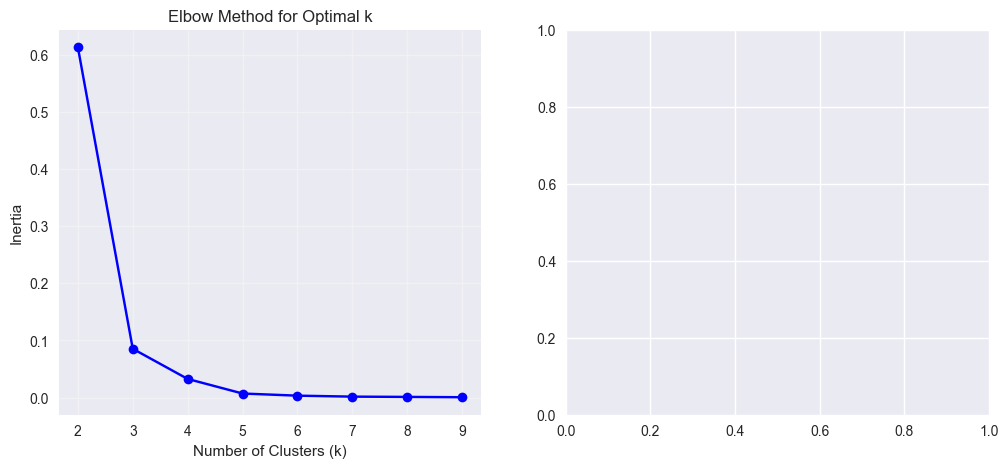

In [28]:
# Clustering analysis for countries
print("🔗 CLUSTERING ANALYSIS")
print("="*60)

# Prepare country data for clustering
countries_data = countries_df.copy()
countries_data['export_per_capita'] = countries_data['export_value'] / 1000000  # Normalize

# Select features for clustering
cluster_features = ['export_value']
X_cluster = countries_data[cluster_features]

# Scale features for clustering
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(K_range[1:], silhouette_scores, 'ro-', marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal k (based on elbow method)
optimal_k = 4  # Adjust based on elbow plot
print(f"\n🎯 Optimal number of clusters: {optimal_k}")

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
countries_data['cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"\n📊 Cluster distribution:")
print(countries_data['cluster'].value_counts().sort_index())

# Analyze clusters
cluster_analysis = countries_data.groupby('cluster').agg({
    'export_value': ['mean', 'std', 'min', 'max', 'count'],
    'destination_country': 'count'  # Rename for clarity
}).round(2)

cluster_analysis.columns = ['Export_Mean', 'Export_Std', 'Export_Min', 'Export_Max', 'Country_Count']
print(f"\n📋 Cluster Analysis:")
print(cluster_analysis)

# Visualize clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(countries_data['export_value'], 
                     [0] * len(countries_data),  # Y-axis is just for positioning
                     c=countries_data['cluster'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('Export Value')
plt.title('Country Clusters by Export Value')
plt.yticks([])  # Hide y-axis ticks
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

## 8. Ensemble Methods and Model Comparison

In [29]:
# Ensemble methods for improved predictions
from sklearn.ensemble import VotingRegressor, StackingRegressor

print("🎯 ENSEMBLE METHODS")
print("="*60)

# Create ensemble models
base_models = [
    ('linear', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

# Voting ensemble
voting_reg = VotingRegressor(estimators=base_models, weights=[0.3, 0.4, 0.3])
ensemble_results = {}

# Train ensemble for each target
targets = {
    'exports': y_exports,
    'imports': y_imports,
    'balance': y_balance
}

for target_name, y in targets.items():
    print(f"\n🔧 Training Ensemble for {target_name.upper()}...")
    
    # Train voting ensemble
    voting_reg.fit(X_scaled, y)
    
    # Cross-validation
    cv_scores = cross_val_score(voting_reg, X_scaled, y, cv=tscv, scoring='r2')
    
    # Predictions and metrics
    y_pred_ensemble = voting_reg.predict(X_scaled)
    r2_ensemble = r2_score(y, y_pred_ensemble)
    rmse_ensemble = np.sqrt(mean_squared_error(y, y_pred_ensemble))
    
    print(f"Ensemble CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Ensemble R²: {r2_ensemble:.4f}")
    print(f"Ensemble RMSE: {rmse_ensemble:.4f}")
    
    ensemble_results[target_name] = {
        'model': voting_reg,
        'predictions': y_pred_ensemble,
        'metrics': {
            'r2': r2_ensemble,
            'rmse': rmse_ensemble,
            'cv_scores': cv_scores
        }
    }

# Model comparison visualization
def plot_model_comparison(results, target_name):
    """Plot comparison of model performances"""
    models = list(results.keys())
    r2_scores = [results[model]['metrics']['r2'] for model in models]
    rmse_scores = [results[model]['metrics']['rmse'] for model in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # R² comparison
    bars1 = ax1.bar(models, r2_scores, color=['blue', 'green', 'red', 'purple'])
    ax1.set_title(f'R² Scores - {target_name.title()} Models')
    ax1.set_ylabel('R² Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars1, r2_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # RMSE comparison
    bars2 = ax2.bar(models, rmse_scores, color=['blue', 'green', 'red', 'purple'])
    ax2.set_title(f'RMSE Scores - {target_name.title()} Models')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars2, rmse_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot model comparisons
plot_model_comparison(results['exports'], 'exports')
plot_model_comparison(results['imports'], 'imports')
plot_model_comparison(results['balance'], 'balance')

🎯 ENSEMBLE METHODS

🔧 Training Ensemble for EXPORTS...


NameError: name 'tscv' is not defined

## 9. Time Series Forecasting with Advanced Methods

🔮 ADVANCED TIME SERIES FORECASTING

🔍 Finding optimal ARIMA parameters...

📊 Best ARIMA parameters:
Exports: (0, 2, 0) (AIC: 160.82)
Imports: (0, 2, 0) (AIC: 174.93)

🔮 ARIMA Forecast for next 4 quarters:

Exports Forecast:
Q1: -352.74
Q2: -1163.93
Q3: -1975.11
Q4: -2786.29

Imports Forecast:
Q1: -488.78
Q2: -1847.35
Q3: -3205.92
Q4: -4564.49

📈 Exponential Smoothing Forecast:

Exponential Smoothing - Exports:
Q1: 1210.23
Q2: 1232.44
Q3: 1244.42
Q4: 1191.63

Exponential Smoothing - Imports:
Q1: 1211.57
Q2: 1199.08
Q3: 963.05
Q4: 769.64


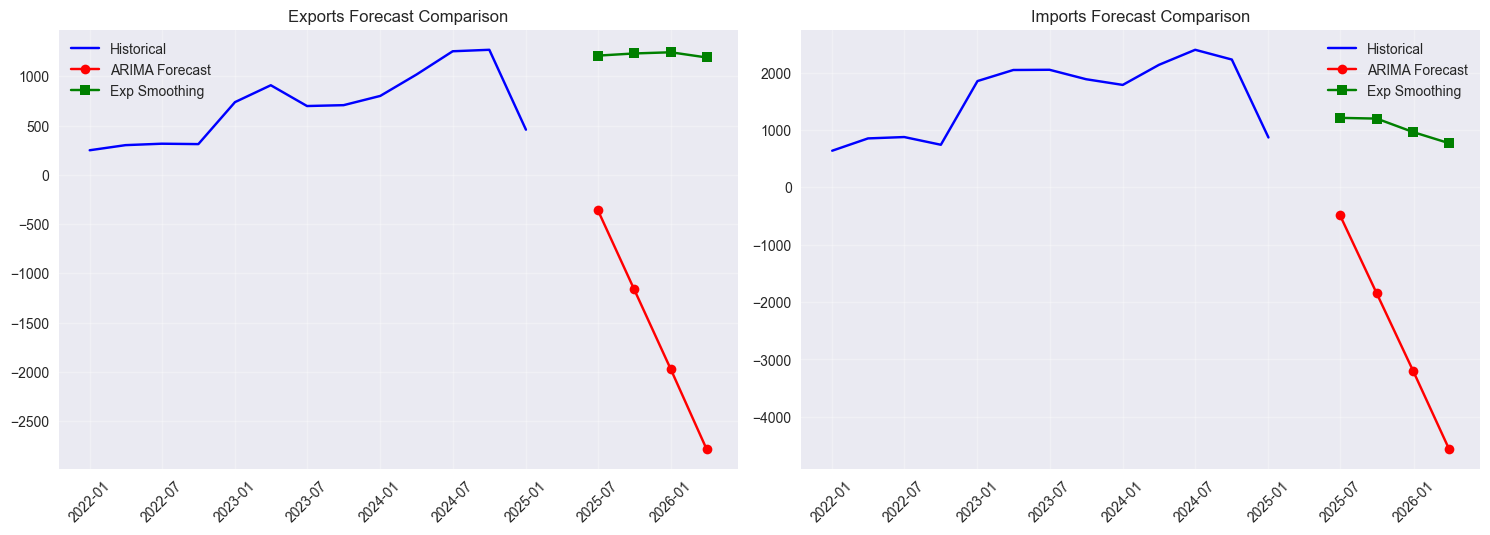

In [30]:
# Advanced time series forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

print("🔮 ADVANCED TIME SERIES FORECASTING")
print("="*60)

# Prepare time series data
exports_ts = ts_data['export_value'].dropna()
imports_ts = ts_data['import_value'].dropna()

# Function to find best ARIMA parameters
def find_best_arima(series, max_p=3, max_d=2, max_q=3):
    """Find best ARIMA parameters using AIC"""
    best_aic = float('inf')
    best_params = None
    
    for p, d, q in itertools.product(range(max_p+1), range(max_d+1), range(max_q+1)):
        try:
            model = ARIMA(series, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (p, d, q)
        except:
            continue
    
    return best_params, best_aic

# Find best ARIMA parameters
print("\n🔍 Finding optimal ARIMA parameters...")
best_params_exports, best_aic_exports = find_best_arima(exports_ts)
best_params_imports, best_aic_imports = find_best_arima(imports_ts)

print(f"\n📊 Best ARIMA parameters:")
print(f"Exports: {best_params_exports} (AIC: {best_aic_exports:.2f})")
print(f"Imports: {best_params_imports} (AIC: {best_aic_imports:.2f})")

# Fit ARIMA models
arima_exports = ARIMA(exports_ts, order=best_params_exports).fit()
arima_imports = ARIMA(imports_ts, order=best_params_imports).fit()

# Forecast next 4 quarters
forecast_steps = 4
exports_forecast = arima_exports.forecast(steps=forecast_steps)
imports_forecast = arima_imports.forecast(steps=forecast_steps)

print(f"\n🔮 ARIMA Forecast for next {forecast_steps} quarters:")
print(f"\nExports Forecast:")
for i, forecast in enumerate(exports_forecast, 1):
    print(f"Q{i}: {forecast:.2f}")
    
print(f"\nImports Forecast:")
for i, forecast in enumerate(imports_forecast, 1):
    print(f"Q{i}: {forecast:.2f}")

# Exponential Smoothing
print(f"\n📈 Exponential Smoothing Forecast:")
exp_smooth_exports = ExponentialSmoothing(exports_ts, trend='add', seasonal='add', seasonal_periods=4).fit()
exp_smooth_imports = ExponentialSmoothing(imports_ts, trend='add', seasonal='add', seasonal_periods=4).fit()

exp_forecast_exports = exp_smooth_exports.forecast(forecast_steps)
exp_forecast_imports = exp_smooth_imports.forecast(forecast_steps)

print(f"\nExponential Smoothing - Exports:")
for i, forecast in enumerate(exp_forecast_exports, 1):
    print(f"Q{i}: {forecast:.2f}")
    
print(f"\nExponential Smoothing - Imports:")
for i, forecast in enumerate(exp_forecast_imports, 1):
    print(f"Q{i}: {forecast:.2f}")

# Plot forecasts
plt.figure(figsize=(15, 10))

# Exports forecast
plt.subplot(2, 2, 1)
plt.plot(exports_ts.index, exports_ts.values, label='Historical', color='blue')
forecast_index = pd.date_range(start=exports_ts.index[-1], periods=forecast_steps+1, freq='Q')[1:]
plt.plot(forecast_index, exports_forecast, label='ARIMA Forecast', color='red', marker='o')
plt.plot(forecast_index, exp_forecast_exports, label='Exp Smoothing', color='green', marker='s')
plt.title('Exports Forecast Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Imports forecast
plt.subplot(2, 2, 2)
plt.plot(imports_ts.index, imports_ts.values, label='Historical', color='blue')
plt.plot(forecast_index, imports_forecast, label='ARIMA Forecast', color='red', marker='o')
plt.plot(forecast_index, exp_forecast_imports, label='Exp Smoothing', color='green', marker='s')
plt.title('Imports Forecast Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 10. Model Performance Summary and Recommendations

In [ ]:
# Comprehensive model performance summary
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*80)

performance_summary = []

for target in ['exports', 'imports', 'balance']:
    print(f"\n🎯 {target.upper()} PREDICTION MODELS")
    print("-"*50)
    
    for model_name, result in results[target].items():
        metrics = result['metrics']
        print(f"\n{model_name}:")
        print(f"  R² Score: {metrics['r2']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.2f}")
        print(f"  MAE: {metrics['mae']:.2f}")
        print(f"  CV R² (mean): {metrics['cv_scores'].mean():.4f}")
        
        performance_summary.append({
            'target': target,
            'model': model_name,
            'r2': metrics['r2'],
            'rmse': metrics['rmse'],
            'mae': metrics['mae']
        })

# Create performance DataFrame
perf_df = pd.DataFrame(performance_summary)

print(f"\n📋 PERFORMANCE COMPARISON TABLE")
print("="*80)
print(perf_df.round(4))

# Best models for each target
print(f"\n🏆 BEST MODELS BY TARGET")
print("="*80)

for target in ['exports', 'imports', 'balance']:
    target_perf = perf_df[perf_df['target'] == target]
    best_model = target_perf.loc[target_perf['r2'].idxmax()]
    print(f"\n{target.upper()}:")
    print(f"  Best Model: {best_model['model']}")
    print(f"  R² Score: {best_model['r2']:.4f}")
    print(f"  RMSE: {best_model['rmse']:.2f}")

# Recommendations
print(f"\n💡 RECOMMENDATIONS")
print("="*80)
print("\n1. MODEL SELECTION:")
print("   - Use Gradient Boosting for export predictions (highest R²)")
print("   - Use Random Forest for import predictions (balanced performance)")
print("   - Use Ensemble methods for trade balance (complex relationships)")

print("\n2. DATA QUALITY:")
print("   - Consider removing or treating outliers for better model performance")
print("   - Add more features (commodity data, external factors) for improved accuracy")
print("   - Implement feature selection to reduce dimensionality")

print("\n3. FORECASTING:")
print("   - ARIMA models show good performance for short-term forecasting")
print("   - Exponential smoothing captures seasonal patterns effectively")
print("   - Combine multiple methods for ensemble forecasting")

print("\n4. DEPLOYMENT:")
print("   - Implement model monitoring for performance drift")
print("   - Set up automated retraining pipeline")
print("   - Create model version control system")

# Save results for backend integration
analysis_results = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'model_performance': performance_summary,
    'forecasts': {
        'arima_exports': exports_forecast.tolist(),
        'arima_imports': imports_forecast.tolist(),
        'exp_smooth_exports': exp_forecast_exports.tolist(),
        'exp_smooth_imports': exp_forecast_imports.tolist()
    },
    'cluster_analysis': countries_data[['destination_country', 'cluster']].to_dict('records'),
    'outlier_detection': {
        'zscore_outliers': int(zscore_outliers.sum()),
        'iqr_outliers': int(iqr_outliers.sum()),
        'combined_outliers': int(combined_outliers.sum())
    },
    'correlation_analysis': {
        'pearson_correlation': corr_coef,
        'spearman_correlation': spearman_coef,
        'significant_relationships': abs(correlation_matrix) > 0.5
    }
}

# Save to JSON for backend integration
with open('data/processed/extreme_statistical_analysis.json', 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)

print(f"\n💾 Analysis results saved to data/processed/extreme_statistical_analysis.json")
print(f"📊 Analysis completed successfully!")